In [3]:
!pip install pyvis > /dev/null

In [4]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/MateoRivera/network-dynamics/refs/heads/main/H1/init.py?token=GHSAT0AAAAAACZHWD3M4LTCY4SSOFRQD7KWZZFABIQ
from init import init; init(force_download=False)


replicating local resources


In [2]:
from scipy.io import loadmat
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp

%matplotlib inline

**Exercise 3.** We are given the highway network in Los Angeles, see Figure 2. To simplify theExercise 3. We are given the highway network in Los Angeles, see Figure 2. To simplify the problem, an approximate highway map is given in Figure 3, covering part of the real highway network. The node-link incidence matrix B, for this traﬃc network is given in the ﬁle traﬃc.mat.
The rows of B are associated with the nodes of the network and the columns of B with the links.
The i-th column of B has 1 in the row corresponding to the tail node of link ei and (−1) in the row corresponding to the head node of link ei. Each node represents an intersection between highways (and some of the area around)
problem, an approximate highway map is given in Figure 3, covering part of the real highway network. The node-link incidence matrix B, for this traffic network is given in the file traffic.mat.
The rows of B are associated with the nodes of the network and the columns of B with the links.
The i-th column of B has 1 in the row corresponding to the tail node of link ei and (−1) in the row corresponding to the head node of link ei. Each node represents an intersection between highways (and some of the area around).

Each link ei ∈ {e1, . . . , e28}, has a maximum flow capacity cei . The capacities are given as a vector ce in the file capacities.mat. Furthermore, each link has a minimum travelling time lei ,
which the drivers experience when the road is empty. In the same manner as for the capacities, the minimum travelling times are given as a vector le in the file traveltime.mat. These values are  [...]



##a
Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.

In [5]:
f = loadmat('resources/flow.mat')["flow"].reshape(28,)
C = loadmat('resources/capacities.mat')["capacities"].reshape(28,)
B = loadmat('resources/traffic.mat')["traffic"]
l = loadmat('resources/traveltime.mat')["traveltime"].reshape(28,)

In [15]:
W = [(
    np.argwhere(b==-1).reshape(-1)[0]+1,
    np.argwhere(b==1).reshape(-1)[0]+1,
    {'time': l[i], 'capacity':C[i]}) for i,b in enumerate(B.T)]

G = nx.Graph()
G.add_weighted_edges_from(W,"time")

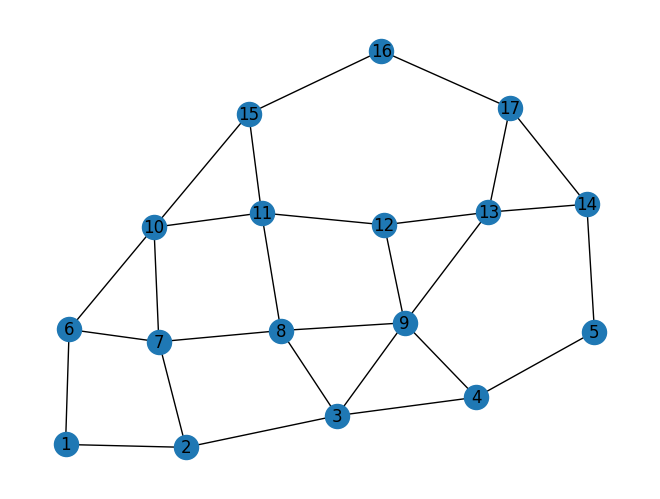

In [12]:
nx.draw(G,with_labels=True)

In [17]:
nx.shortest_path(G,1,17)

[1, 2, 3, 9, 13, 17]

In [19]:
nx.maximum_flow(G,1,17, capacity='time')

TypeError: '>' not supported between instances of 'dict' and 'int'

In [98]:
np.greater_equal(f,C)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

There's not any flow greater than it's capacity

In [37]:
def tau_e(le,fe,ce):
    return (le)/(1-(fe/ce))

tau_e = np.vectorize(tau_e)

In [41]:
tau_e(l,f,C)

array([0.81385187, 0.16425176, 0.77890095, 1.24060609, 0.40216493,
       0.97010263, 1.0052853 , 0.55488373, 2.57831211, 0.75572643,
       0.64312759, 0.60783782, 0.37276437, 1.48290744, 0.77119811,
       0.68057619, 0.7039339 , 0.40328494, 0.12835809, 0.24764477,
       0.76798977, 0.92208754, 0.4690847 , 0.18976613, 1.10261191,
       0.27798866, 1.22283492, 1.43592615])

In [67]:
n_edges = B.shape[1]

# exogenous flow vector: one unit of flow enters the origin and exits the destination node
# the solution of the shortest path problem is actually independent on the throughput value because of the linearity
tau = tau_e(l,f,C)

nu = np.zeros((n_edges,1))


In [69]:
objective = cp.Minimize(l.T @ f)
constraints = [B @ f == cp.Parameter(value=nu), f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Optimal f:", f.value)

ValueError: Invalid dimensions (28, 1) for Parameter value.

##b